<a href="https://colab.research.google.com/github/Aakash3101/Deep-Learning/blob/master/ML/Deep_learning/pytorch_tutorials/cifar10/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **ResNet and other optimizations for CNNs**

In [76]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
project_name = '05b-cifar10-resnet'

## **Preparing the Data**

In [25]:
# Download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-sample/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['test', 'labels.txt', 'train']
['airplane', 'dog', 'deer', 'ship', 'frog', 'automobile', 'cat', 'bird', 'horse', 'truck']


In [26]:
len(os.listdir(data_dir + '/train/horse'))

5000

There are a few important changes we'll make while creating the PyTorch datasets:

1. **Use test set for validation:** Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set **(Only when you have labels for your test set)**. This just gives a little more data to train with. In general, once you have picked the best model architecture & hyperparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance

2. **Channel-wise data normalization:** We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values than others.

3. **Randomized data augmentations:** We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32x32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

In [78]:
# Data transforms (normalization and data augmentation)

# Mean and Standard Deviation for each color channel
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [79]:
# PyTorch datasets

train_ds = ImageFolder(data_dir + '/train', train_tfms)
val_ds = ImageFolder(data_dir + '/test', valid_tfms)

In [80]:
batch_size = 300

In [81]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

In [82]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


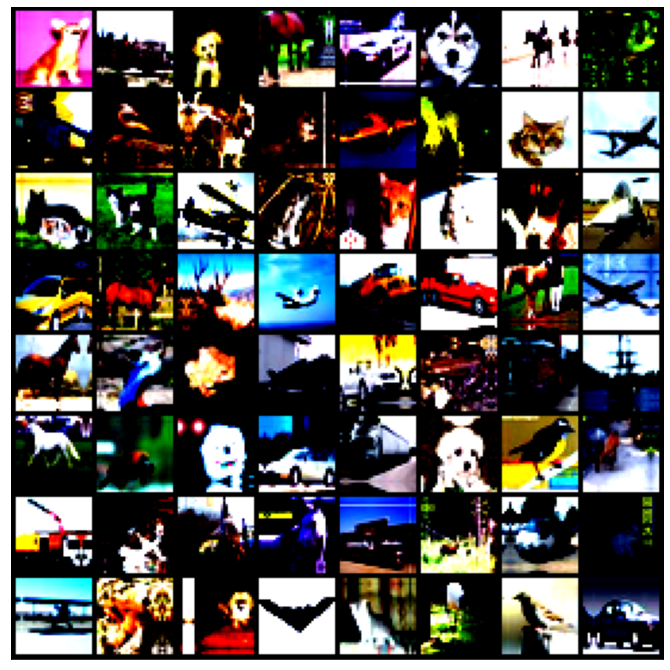

In [83]:
show_batch(train_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## **Using the GPU**

In [84]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [85]:
device = get_default_device()
device

device(type='cuda')

In [86]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## **Model with Residual Blocks and Batch Normalization**

One of the key changes to our CNN model this time is the addition of the residual block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

        x     | - - - - - - - - -
              |                  |
        ( weight layer )         |
              |                  |
    F(x)      |     relu         |   x identity
              |                  |
        ( weight layer )         |
              |                  |
    F(x)+x   (+) - - - - - - - - -
              |      relu
              |
              V

In [87]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x      # ReLU can be applied before or after adding the input

In [88]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([300, 3, 32, 32])


## **Creating the model**

We will be using the ResNet9 architecture

In [89]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                          # Generate Predictions
        loss = F.cross_entropy(out, labels)         # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                          # Generate predictions
        loss = F.cross_entropy(out, labels)         # Calculate loss
        acc = accuracy(out, labels)                 # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()          # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [90]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)        # batch_size x 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True)     # batch_size x 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))   # batch_size x 128 x 16 x 16

        self.conv3 = conv_block(128, 256, pool=True)    # batch_size x 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)    # batch_size x 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))   # batch_size x 512 x 4 x 4

        self.classifier = nn.Sequential(nn.MaxPool2d(4),                # batch_size x 512 x 1 x 1
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [118]:
model =  to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## **Training the Model**

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

- **Learning rate scheduling:** Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "*One Cycle Learning Rate Policy*", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% epochs, then gradually decreasing it to a very low value for the remaining epochs.

- **Weight decay:** We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

- **Gradient clipping:** Apart from the layer weights and outputs, it's also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.

Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [92]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [119]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.09803921729326248, 'val_loss': 2.305701494216919}]

In [121]:
epochs = 14
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [122]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip=grad_clip, weight_decay=weight_decay,)

Epoch [0], last_lr: 0.00167, train_loss: 1.3157, val_loss: 1.1815, val_acc: 0.5965
Epoch [1], last_lr: 0.00483, train_loss: 0.8789, val_loss: 0.8461, val_acc: 0.7040
Epoch [2], last_lr: 0.00819, train_loss: 0.8203, val_loss: 0.7912, val_acc: 0.7323
Epoch [3], last_lr: 0.00995, train_loss: 0.7238, val_loss: 0.7393, val_acc: 0.7640
Epoch [4], last_lr: 0.00984, train_loss: 0.5896, val_loss: 0.6332, val_acc: 0.7840
Epoch [5], last_lr: 0.00919, train_loss: 0.5038, val_loss: 0.7603, val_acc: 0.7509
Epoch [6], last_lr: 0.00812, train_loss: 0.4490, val_loss: 0.5809, val_acc: 0.8071
Epoch [7], last_lr: 0.00673, train_loss: 0.3876, val_loss: 0.6709, val_acc: 0.7898
Epoch [8], last_lr: 0.00516, train_loss: 0.3488, val_loss: 0.4424, val_acc: 0.8488
Epoch [9], last_lr: 0.00358, train_loss: 0.2879, val_loss: 0.3728, val_acc: 0.8744
Epoch [10], last_lr: 0.00214, train_loss: 0.2295, val_loss: 0.3084, val_acc: 0.8991
Epoch [11], last_lr: 0.00099, train_loss: 0.1663, val_loss: 0.2649, val_acc: 0.9103
Ep

In [55]:
# ruder.io/optimizing-gradient-descent/index.html

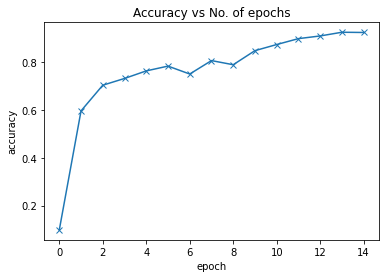

In [123]:
# Plotting accuracies

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs');

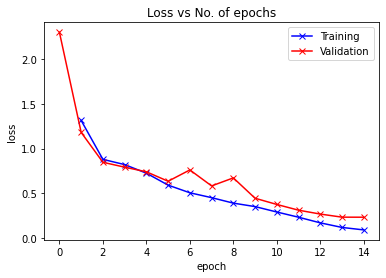

In [124]:
# Plotting losses

train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs No. of epochs');

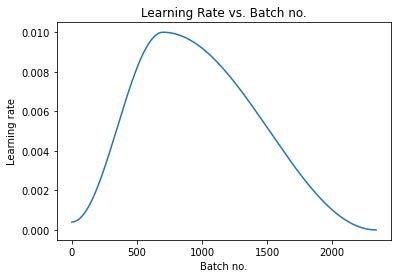

In [125]:
# Plotting Learning rates

lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.plot(lrs)
plt.xlabel('Batch no.')
plt.ylabel('Learning rate')
plt.title('Learning Rate vs. Batch no.');

In [129]:
torch.cuda.empty_cache()

In [130]:
!nvidia-smi

Tue Nov  3 17:53:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    56W / 149W |   2409MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Observation Table
---
Model 1:

```
```

---
| Model S.no | I (Lr, Epochs) | II (Lr, Epochs) | optimizer | val_acc | test_acc |
| --- | --- | --- | --- | --- | --- |
| 1 | (0.1, 20) | (0.01, 10) | SGD | 55.37 | 54.74 |
| 1 | (0.2, 20) | (0.1, 10) | SGD | 49.40 | 48.86 |
| 1 | (0.5, 20) | (0.1, 10) | SGD | 48.87 | 50.66 |
| 1 | (0.1, 30) | (0.01, 10) | SGD | 55.66 | 55.31 |
| 1 | (0.001, 20) | (0.0001, 10) | Adam | 53.04 | 53.34 |
| 1 | (0.0001, 20) | (1e-5, 10) | Adam | 51.62 | 52.17 |

---

In [ ]:
torch.cuda.empty_cache()